In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from statsmodels.tools.tools import add_constant
from statsmodels.stats.outliers_influence import variance_inflation_factor
# To preprocess the data
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder,OneHotEncoder

In [2]:
current_path = os.getcwd()

In [3]:
current_path

'/Users/kuldeepchinwan/Projects/ML_Projects/customer-churn-prediction/notebooks'

In [4]:
os.chdir('..')

In [5]:
os.chdir('/Users/kuldeepchinwan/Projects/ML_Projects/customer-churn-prediction/data/raw')

In [6]:
raw_df = pd.read_csv('Telco_customer_churn.csv')

In [7]:
raw_df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [8]:
raw_df.drop(columns = ['customerID'], inplace = True)

In [9]:
raw_df['TotalCharges'] = pd.to_numeric(raw_df['TotalCharges'], errors = 'coerce')
raw_df['SeniorCitizen'] = raw_df['SeniorCitizen'].astype(str)

In [10]:
# Identify numerical and categorical columns dynamically
numerical_features = raw_df.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = raw_df.select_dtypes(include=['object']).columns.tolist()

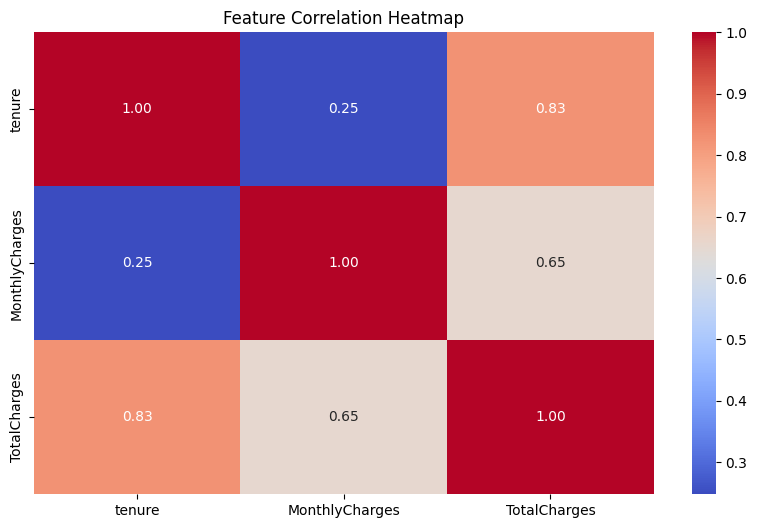

In [11]:
#heat map to show the correlation between numerical data
plt.figure(figsize=(10, 6))
sns.heatmap(raw_df[numerical_features].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Feature Correlation Heatmap")
plt.show()

In [12]:
# Removing outliers in numerical features
# Define function to remove outliers using IQR
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

df = remove_outliers_iqr(raw_df, numerical_features)

In [13]:
#Checking Correlation Between Features
# Compute correlation matrix
correlation_matrix = df[numerical_features].corr()
correlation_matrix

,tenure,MonthlyCharges,TotalCharges
tenure,1.000000,0.246862,0.825880
MonthlyCharges,0.246862,1.000000,0.651065
TotalCharges,0.825880,0.651065,1.000000


**********Encode The Data By OneHotEncoder**********

In [14]:
# Apply OneHotEncoder
encoder = OneHotEncoder(sparse_output=False)  # Setting drop='first' to avoid multicollinearity
encoded_data = encoder.fit_transform(df[categorical_features])

In [15]:
# Create a DataFrame from the encoded data
encoded_df = pd.DataFrame(encoded_data, columns=encoder.get_feature_names_out(categorical_features))

In [16]:
encoded_df.columns

Index(['gender_Female', 'gender_Male', 'SeniorCitizen_0', 'SeniorCitizen_1',
       'Partner_No', 'Partner_Yes', 'Dependents_No', 'Dependents_Yes',
       'PhoneService_No', 'PhoneService_Yes', 'MultipleLines_No',
       'MultipleLines_No phone service', 'MultipleLines_Yes',
       'InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'OnlineSecurity_No',
       'OnlineSecurity_No internet service', 'OnlineSecurity_Yes',
       'OnlineBackup_No', 'OnlineBackup_No internet service',
       'OnlineBackup_Yes', 'DeviceProtection_No',
       'DeviceProtection_No internet service', 'DeviceProtection_Yes',
       'TechSupport_No', 'TechSupport_No internet service', 'TechSupport_Yes',
       'StreamingTV_No', 'StreamingTV_No internet service', 'StreamingTV_Yes',
       'StreamingMovies_No', 'StreamingMovies_No internet service',
       'StreamingMovies_Yes', 'Contract_Month-to-month', 'Contract_One year',
       'Contract_Two year', 'PaperlessBilling_No', 'Paperle

In [17]:
# Drop the original categorical columns from the DataFrame
df.drop(columns=categorical_features, inplace=True)

In [18]:
# Reset index of the DataFrame
df.reset_index(drop=True, inplace=True)

In [19]:
# Concatenate the original DataFrame with the encoded DataFrame
df = pd.concat([df, encoded_df], axis=1)

In [20]:
df.drop('Churn_No', axis=1, inplace=True)

In [21]:
df.head()

,tenure,MonthlyCharges,TotalCharges,gender_Female,gender_Male,SeniorCitizen_0,SeniorCitizen_1,Partner_No,Partner_Yes,Dependents_No,...,Contract_Month-to-month,Contract_One year,Contract_Two year,PaperlessBilling_No,PaperlessBilling_Yes,PaymentMethod_Bank transfer (automatic),PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,Churn_Yes
0,1,29.85,29.85,1.0,0.0,1.0,0.0,0.0,1.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,34,56.95,1889.50,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2,2,53.85,108.15,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0
3,45,42.30,1840.75,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0
4,2,70.70,151.65,1.0,0.0,1.0,0.0,1.0,0.0,1.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0


In [22]:
# rename churn_yes to churn
df.rename(columns={'Churn_Yes': 'Churn'}, inplace=True)

In [23]:
df.to_csv('processed_churn_data.csv')